In [1]:
import os
import yaml
from pathlib import Path
from functools import partial

import torch
import torch.nn as nn
from torch.nn import DataParallel

from DINO4Cells_code.archs import vision_transformer as vits
from DINO4Cells_code.archs.vision_transformer import DINOHead
from DINO4Cells_code.archs import xresnet as cell_models  # (!)
from DINO4Cells_code.utils import utils

In [2]:
config_file = Path("/home/ishang/HPA-embedding/dino_config.yaml")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = yaml.safe_load(open(config_file, "r"))

In [3]:
if config["model"]["model_type"] == "DINO":
        if config["model"]["arch"] in vits.__dict__.keys():
            print("config['model']['arch'] {} in vits".format(config["model"]["arch"]))
            # model = vits.__dict__[config['model']['arch']](img_size=[112], patch_size=config['model']['patch_size'], num_classes=0, in_chans=config['model']['num_channels'])
            # model = vits.__dict__[config['model']['arch']](img_size=[512], patch_size=config['model']['patch_size'], num_classes=0, in_chans=config['model']['num_channels'])
            model = vits.__dict__[config["model"]["arch"]](
                img_size=[224],
                patch_size=config["model"]["patch_size"],
                num_classes=0,
                in_chans=config["model"]["num_channels"],
            )
            # model = vits.__dict__[config['model']['arch']](img_size=[224], patch_size=config['model']['patch_size'], num_classes=0, in_chans=config['model']['num_channels'])
            embed_dim = model.embed_dim
        elif config["model"]["arch"] in cell_models.__dict__.keys():
            print(f"config['model']['arch'] {config['model']['arch']} in cell_models")
            model = partial(
                cell_models.__dict__[config["model"]["arch"]],
                c_in=config["model"]["num_channels"],
            )(False)
            embed_dim = model[-1].in_features
            model[-1] = nn.Identity()

        if config["embedding"]["HEAD"] == True:
            model = utils.MultiCropWrapper(
                model,
                DINOHead(
                    embed_dim,
                    config["model"]["out_dim"],
                    config["model"]["use_bn_in_head"],
                ),
            )

        for p in model.parameters():
            p.requires_grad = False

        model.eval()
        model.to(device)
        pretrained_weights = config["embedding"]["pretrained_weights"]
        print(f'loaded {config["embedding"]["pretrained_weights"]}')

        if os.path.isfile(pretrained_weights):
            state_dict = torch.load(pretrained_weights, map_location="cpu")
            if "teacher" in state_dict:
                teacher = state_dict["teacher"]
                if not config["embedding"]["HEAD"] == True:
                    teacher = {k.replace("module.", ""): v for k, v in teacher.items()}
                    teacher = {
                        k.replace("backbone.", ""): v for k, v in teacher.items()
                    }
                msg = model.load_state_dict(teacher, strict=False)
            else:
                student = state_dict
                if not config["embedding"]["HEAD"] == True:
                    student = {k.replace("module.", ""): v for k, v in student.items()}
                    student = {
                        k.replace("backbone.", ""): v for k, v in student.items()
                    }
                student = {k.replace("0.", ""): v for k, v in student.items()}
                msg = model.load_state_dict(student, strict=False)

            for p in model.parameters():
                p.requires_grad = False
            model = model.cuda()
            model = model.eval()
            model = DataParallel(model)
            print(
                "Pretrained weights found at {} and loaded with msg: {}".format(
                    pretrained_weights, msg
                )
            )
        else:
            print(
                "Checkpoint file not found at {}. Please check and retry".format(
                    pretrained_weights
                )
            )
            quit()

config['model']['arch'] vit_base in vits
loaded /data/ishang/HPA_single_cells_data/HPA_single_cell_model_checkpoint.pth
Pretrained weights found at /data/ishang/HPA_single_cells_data/HPA_single_cell_model_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])


In [11]:
imsize = 256 * 3
batch_size = 100
# DATA_DIR = Path("/data/ishang/FUCCI-dataset-well/")
# NAME = "well_spline_norm_512_crop_sharpness_1250"
DATA_DIR = Path("/data/ishang/CCNB1-dataset/")
NAME = "full_res_768_crop_min_max_border_1250_sharp"

In [12]:
from data import CellImageDataset
# dataset = CellImageDataset(DATA_DIR / f"index_{NAME}.csv", channel_colors=["pure_blue", "pure_yellow", "pure_green", "pure_red"], batch_size=batch_size)
dataset = CellImageDataset(DATA_DIR / f"index_{NAME}.csv", channel_colors=["pure_blue", "pure_red", "pure_green"], batch_size=batch_size)

Loading dataset images:   0%|          | 0/18 [00:00<?, ?it/s]

Loading dataset images: 100%|██████████| 18/18 [04:00<00:00, 13.38s/it]

Loaded 25466 images from 1712 files.


In [13]:
print(len(dataset))
print(dataset[0].shape)

25466
torch.Size([3, 768, 768])


In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

DataParallel(
  (module): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(4, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (norm): Layer

In [20]:
cleared_sample = dataset[0:10]
print(cleared_sample.shape)
cleared_sample[:, 2:] = 0
# cleared_sample[:, 3] = 0
while cleared_sample.shape[1] < 4:
    cleared_sample = torch.cat([cleared_sample, torch.zeros_like(cleared_sample[:, 0:1])], dim=1)
print(cleared_sample.shape)
cleared_sample.to(device)

torch.Size([10, 3, 768, 768])
torch.Size([10, 4, 768, 768])


tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          

In [22]:
cls_hopefully = model(cleared_sample)
print(cls_hopefully.shape)

torch.Size([10, 768])


In [24]:
# clear dataset fucci channels and run through model, collect the cls tokens and save the output
from tqdm import tqdm

cls_tokens = []
batch_size = 64
for i in tqdm(range(0, len(dataset), batch_size)):
    cleared_sample = dataset[i:i+batch_size]
    cleared_sample[:, 2:] = 0
    # cleared_sample[:, 3] = 0
    while cleared_sample.shape[1] < 4:
        cleared_sample = torch.cat([cleared_sample, torch.zeros_like(cleared_sample[:, 0:1])], dim=1)
    cleared_sample.to(device)
    cls = model(cleared_sample)
    cls_tokens.append(cls)
cls_tokens = torch.cat(cls_tokens, dim=0).cpu()
print(cls_tokens.shape)
torch.save(cls_tokens, DATA_DIR / f"HPA_DINO_cls_{NAME}.pt")

100%|██████████| 398/398 [03:50<00:00,  1.73it/s]


torch.Size([25466, 768])


In [25]:
# Plot PCA of cls tokens by pseudotime
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# get 5000 random cls tokens
cls_tokens = torch.load(DATA_DIR / f"HPA_DINO_cls_{NAME}.pt")
indices = np.random.choice(len(cls_tokens), 5000, replace=False)
cls_tokens = cls_tokens[indices]
pseudo_time = np.load(DATA_DIR / f"FUCCI_pseudotime_{NAME}.npy")[indices]
cls_tokens = cls_tokens.cpu().detach().numpy()
pca = PCA(n_components=100)
cls_tokens_pca = pca.fit_transform(cls_tokens)
plt.scatter(cls_tokens_pca[:, 0], cls_tokens_pca[:, 1], c=pseudo_time, cmap="RdYlGn")
plt.colorbar()
plt.show()

# Plot PCA explained variance
plt.clf()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/data/ishang/CCNB1-dataset/FUCCI_pseudotime_full_res_768_crop_min_max_border_1250_sharp.npy'

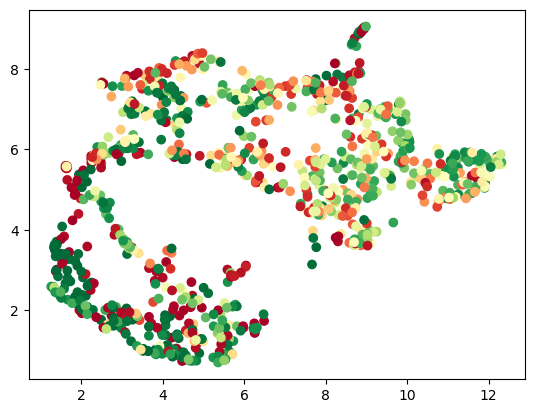

In [43]:
# Try plotting the UMAP
import umap
reducer = umap.UMAP()
cls_tokens_umap = reducer.fit_transform(cls_tokens)
plt.scatter(cls_tokens_umap[:, 0], cls_tokens_umap[:, 1], c=pseudo_time, cmap="RdYlGn")

In [48]:
dinov2_cls = torch.load(DATA_DIR / f"ref_embeddings_{NAME}.pt")[indices]

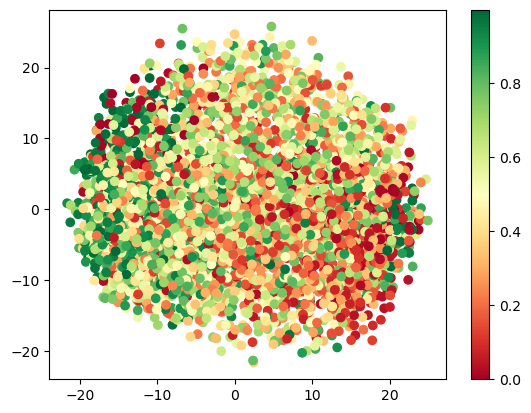

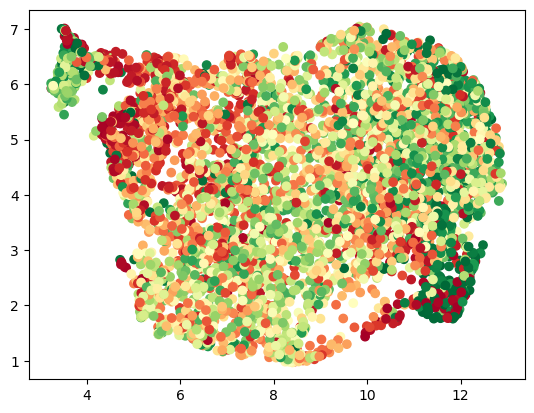

: 

In [49]:
# do PCA and UMAP on the dinov2_cls tokens

pca = PCA(n_components=100)
dinov2_cls_pca = pca.fit_transform(dinov2_cls[:len(cls_tokens)])
plt.scatter(dinov2_cls_pca[:, 0], dinov2_cls_pca[:, 1], c=pseudo_time, cmap="RdYlGn")
plt.colorbar()
plt.show()

reducer = umap.UMAP()
dinov2_cls_umap = reducer.fit_transform(dinov2_cls)
plt.clf()
plt.scatter(dinov2_cls_umap[:, 0], dinov2_cls_umap[:, 1], c=pseudo_time, cmap="RdYlGn")
plt.show()